In [4]:
# TODO
# Collect at least 1000 gray image
# resize them 32X32 (1024)
# construct data matrix and covariance matrix using face image
# SVD ( PCA ) to the covariance matrix
# eigenvectors for largest singular values
# FINAL : Test for the recognition

In [5]:
import cv2
import os
import numpy as np
import random
from matplotlib import pyplot as plt

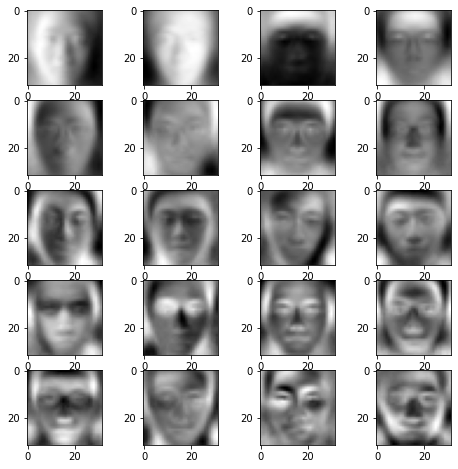

In [7]:
file_M_path = "./res/faces/M/"
file_F_path = "./res/faces/F/"
file_M_list = os.listdir("./res/faces/M/")
file_F_list = os.listdir("./res/faces/F/")

man_pics = []
for file_M in file_M_list:
    man_pics.append(np.array(
        cv2.resize(cv2.imread(file_M_path + file_M, 0), dsize=(32, 32), interpolation=cv2.INTER_AREA)
    ,dtype=np.float64).flatten())

sum_of_pics = sum(man_pics)

mean_of_pics = sum_of_pics / len(man_pics)

translation = man_pics - mean_of_pics

U, s, V = np.linalg.svd(translation, full_matrices = True)

S = np.zeros(translation.shape)
for i in range(len(s)):
     S[i][i] = s[i]

appA = np.dot(U, np.dot(S, V))

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = V[i].reshape(32,32)
#     img = l[np.random.randint(1024)].reshape(32,32)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
plt.show()

In [8]:
"""
face_cascade = cv2.CascadeClassifier('haarcascade_frontface.xml')
original_path = "./res/original/"
test_file_list = os.listdir(original_path)
for folder in test_file_list[3]:
    files = os.listdir(original_path + folder)
    for i, file_path in enumerate(files):
        cur_path = original_path + folder + "/"
        frame = cv2.imread(cur_path + file_path)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        if len(faces):
            directory = os.path.dirname(cur_path + "ex/")
            if not os.path.exists(directory):
                print("Make")
                os.makedirs(directory)
            print("face detected")
            x,y,w,h = faces[0]
            print(cur_path + "ex/" + "result-" + str(i) + ".jpg")
            cv2.imwrite(cur_path + "ex/" + "result-" + str(i) + ".jpg", frame[y:y+h, x:x+w])
"""

'\nface_cascade = cv2.CascadeClassifier(\'haarcascade_frontface.xml\')\noriginal_path = "./res/original/"\ntest_file_list = os.listdir(original_path)\nfor folder in test_file_list[3]:\n    files = os.listdir(original_path + folder)\n    for i, file_path in enumerate(files):\n        cur_path = original_path + folder + "/"\n        frame = cv2.imread(cur_path + file_path)\n        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)\n        faces = face_cascade.detectMultiScale(gray, 1.3, 5)\n        if len(faces):\n            directory = os.path.dirname(cur_path + "ex/")\n            if not os.path.exists(directory):\n                print("Make")\n                os.makedirs(directory)\n            print("face detected")\n            x,y,w,h = faces[0]\n            print(cur_path + "ex/" + "result-" + str(i) + ".jpg")\n            cv2.imwrite(cur_path + "ex/" + "result-" + str(i) + ".jpg", frame[y:y+h, x:x+w])\n'

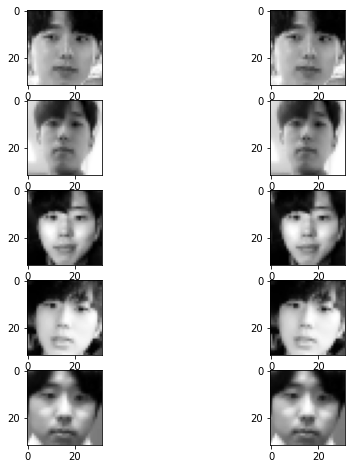

In [9]:
test_path = "./res/original/9/ex/"
test_file_list = os.listdir(test_path)
test_pics = []
weights = []
for test_file in test_file_list:
    pic = np.array(cv2.resize(cv2.imread(test_path + test_file, 0), dsize=(32, 32), interpolation=cv2.INTER_AREA), dtype=np.float64).flatten()
    test_pics.append(pic)
    weights.append((pic - mean_of_pics) @ V.T)

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = len(test_file_list)
for i in range(rows):
    original_img = test_pics[i].reshape(32,32)
    w = np.diag(weights[i])
    restored_img = w @ V
    restored_img = (sum(restored_img[:1024]) + mean_of_pics).reshape(32, 32)
    fig.add_subplot(rows, columns, 2*i + 1)
    plt.imshow(original_img, cmap='gray')
    fig.add_subplot(rows, columns, 2*i + 2)
    plt.imshow(restored_img, cmap='gray')
plt.show()

In [10]:
# Measuring similarity
test_faces_path = "./res/original/"
test_folders = os.listdir(test_faces_path)
face_eigen_values = []

def find_sim(ev, faces_eigen):
    euclidean_distances = []
    cosine_similarities = []
    for idx, pivot in enumerate(faces_eigen):
        euclidean_distances.append(np.linalg.norm(ev - ev @ pivot * pivot))
        cosine_similarities.append(ev @ pivot / np.linalg.norm(ev))
    return euclidean_distances , cosine_similarities

for test_folder in test_folders:
    face_files = os.listdir(test_faces_path + test_folder + "/ex/")
    cropped_path = test_faces_path + test_folder + "/ex/"
    eigens = []
    for face_file in face_files:
        face_vec = np.array(cv2.resize(cv2.imread(cropped_path + face_file, 0), dsize=(32, 32), interpolation=cv2.INTER_AREA), dtype=np.float64).flatten()
        eigens.append(face_vec @ V.T)
    face_eigen_values.append(eigens)
    
mean_eigen_values = []
for fev in face_eigen_values:
    mean_eigen = sum(fev) / len(fev)
    mean_eigen_values.append(mean_eigen / np.linalg.norm(mean_eigen))

for i, face_eigen_list in enumerate(face_eigen_values):
    pivot_vec = mean_eigen_values[i] / np.linalg.norm(mean_eigen_values[i])
    print("TEST {} face".format(str(i)))
    for fev in face_eigen_list:
        e, c = find_sim(fev, mean_eigen_values)
        se = sorted(e)
        sc = sorted(c, reverse=True)
        
        print("euclidean 1st {}, 2nd {}".format(np.where(e == se[0])[0][0], np.where(e == se[1])[0][0], se[1] * 100))
        print("cosine    1st {}, 2nd {}".format(np.where(c == sc[0])[0][0], np.where(c == sc[1])[0][0], sc[1] * 100))
        
    print("")

[array([-9.75214893e-01, -6.96441251e-02,  3.47553421e-02, ...,
        7.70478269e-05, -1.55658739e-05,  1.22181268e-04]), array([-9.83251900e-01, -1.11386959e-01, -5.95717544e-02, ...,
       -1.84003273e-04, -1.87387171e-04,  5.26923927e-05]), array([-9.71186208e-01, -7.38958981e-02, -1.68735829e-02, ...,
        1.93073290e-04, -4.87340050e-06,  1.25297850e-04]), array([-9.47798906e-01, -6.77674474e-02,  2.23700821e-01, ...,
        3.85121942e-05, -4.08020129e-04,  1.22336881e-04]), array([-9.79954634e-01, -4.75470548e-02,  2.68423083e-02, ...,
       -1.33624002e-04, -1.65097091e-04, -2.11750377e-05]), array([-9.78510405e-01, -1.29227766e-01, -2.49063227e-02, ...,
        7.53681583e-05, -2.46203183e-04, -3.76102707e-04]), array([-9.76473932e-01, -1.09943088e-01,  4.67881930e-03, ...,
        2.61364007e-04, -1.48164980e-05,  3.11918599e-05]), array([-9.70969301e-01, -7.79420108e-02,  1.16402550e-01, ...,
       -1.74250319e-04, -6.73655906e-05, -4.73265576e-05]), array([-9.67561

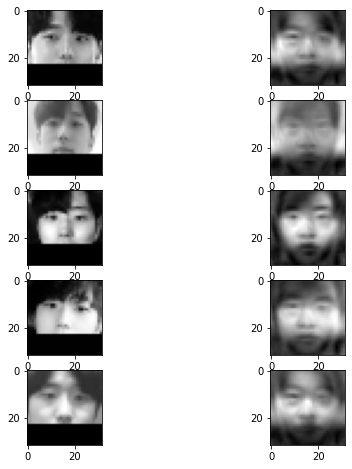

In [11]:
test_path = "./res/original/9/ex/"
test_file_list = os.listdir(test_path)
test_pics = []
weights = []
for test_file in test_file_list:
    pic = np.array(cv2.resize(cv2.imread(test_path + test_file, 0), dsize=(32, 32), interpolation=cv2.INTER_AREA), dtype=np.float64).flatten()
    pic = np.concatenate((pic[:512 + 224], np.array([1 for i in range(512 - 224)])))
    test_pics.append(pic)
    weights.append((pic - mean_of_pics) @ V.T)

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = len(test_file_list)
for i in range(rows):
    original_img = test_pics[i].reshape(32,32)
    w = np.diag(weights[i])
    restored_img = w @ V
    restored_img = (sum(restored_img[:56]) + mean_of_pics).reshape(32, 32)
    fig.add_subplot(rows, columns, 2*i + 1)
    plt.imshow(original_img, cmap='gray')
    fig.add_subplot(rows, columns, 2*i + 2)
    plt.imshow(restored_img, cmap='gray')
plt.show()

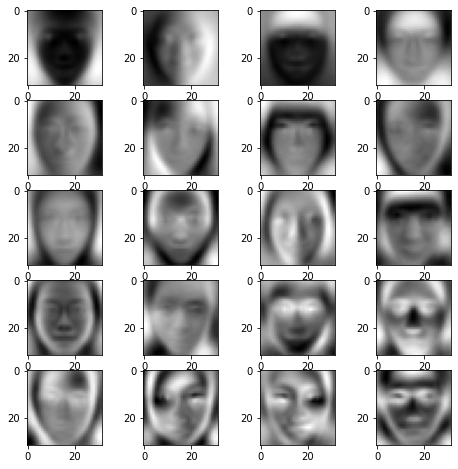

In [12]:
file_M_path = "./res/faces/M/"
file_F_path = "./res/faces/F/"
file_M_list = os.listdir("./res/faces/M/")
file_F_list = os.listdir("./res/faces/F/")

people_pics = []
for file_M in file_M_list:
    people_pics.append(np.array(
        cv2.resize(cv2.imread(file_M_path + file_M, 0), dsize=(32, 32), interpolation=cv2.INTER_AREA)
    ,dtype=np.float64).flatten())

for file_F in file_F_list:
    people_pics.append(np.array(
        cv2.resize(cv2.imread(file_F_path + file_F, 0), dsize=(32, 32), interpolation=cv2.INTER_AREA)
    ,dtype=np.float64).flatten())
random.shuffle(people_pics)
sum_of_pics = sum(people_pics)

mean_of_pics = sum_of_pics / len(people_pics)

translation = people_pics - mean_of_pics

U, s, V = np.linalg.svd(translation, full_matrices = True)

S = np.zeros(translation.shape)
for i in range(len(s)):
     S[i][i] = s[i]

appA = np.dot(U, np.dot(S, V))

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = V[i].reshape(32,32)
#     img = l[np.random.randint(1024)].reshape(32,32)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
plt.show()

In [13]:
# Measuring similarity
test_faces_path = "./res/original/"
test_folders = os.listdir(test_faces_path)
face_eigen_values = []

def find_sim(ev, faces_eigen):
    euclidean_distance = np.linalg.norm(ev - ev @ faces_eigen[0] * faces_eigen[0])
    euclidean_idx = 0
    cosine_similarity = ev @ faces_eigen[0] / np.linalg.norm(ev)
    cosine_idx = 0
    for idx, pivot in enumerate(faces_eigen):
        ed = np.linalg.norm(ev - ev @ pivot * pivot)
        cs = ev @ pivot / np.linalg.norm(ev)
        if euclidean_distance > ed:
            euclidean_distance = ed
            euclidean_idx = idx
        if cosine_similarity < cs:
            cosine_similarity = cs
            cosine_idx = idx
    return euclidean_idx, cosine_idx

for test_folder in test_folders:
    face_files = os.listdir(test_faces_path + test_folder + "/ex/")
    cropped_path = test_faces_path + test_folder + "/ex/"
    eigens = []
    for face_file in face_files:
        face_vec = np.array(cv2.resize(cv2.imread(cropped_path + face_file, 0), dsize=(32, 32), interpolation=cv2.INTER_AREA), dtype=np.float64).flatten()
        eigens.append(face_vec @ V.T)
    face_eigen_values.append(eigens)
    
mean_eigen_values = []
for fev in face_eigen_values:
    mean_eigen = sum(fev) / len(fev)
    mean_eigen_values.append(mean_eigen / np.linalg.norm(mean_eigen))

for i, face_eigen_list in enumerate(face_eigen_values):
    pivot_vec = mean_eigen_values[i] / np.linalg.norm(mean_eigen_values[i])
    print("TEST {} face".format(str(i)))
    for fev in face_eigen_list:
        e, c = find_sim(fev, mean_eigen_values)
        print("{}, {}".format(str(e), str(c)))
    print("")

[array([ 9.61782138e-01,  1.19815016e-02,  7.28637917e-02, ...,
        2.65236374e-05, -7.13060535e-05,  2.00428128e-04]), array([9.81710577e-01, 1.03736200e-01, 7.41538281e-02, ...,
       9.31579595e-05, 1.90702372e-04, 4.81141251e-05]), array([ 9.63207476e-01,  5.96592468e-02,  5.79572416e-02, ...,
       -2.57599551e-04,  7.92966130e-05,  7.48839877e-05]), array([ 9.47834761e-01, -1.71777033e-01,  1.40027233e-01, ...,
        9.36640292e-05,  1.69989005e-04,  6.80968152e-05]), array([ 9.65442347e-01,  1.04350396e-03,  5.15310104e-02, ...,
        2.37283452e-04,  1.54132474e-04, -1.16469461e-04]), array([ 9.83289555e-01,  7.97150235e-02,  9.98035776e-02, ...,
        1.31262874e-04,  3.95730134e-04, -7.48740655e-05]), array([ 9.71200416e-01,  4.58541226e-02,  9.87445009e-02, ...,
       -1.57872855e-04, -1.04169448e-04,  5.89918543e-05]), array([ 9.68371426e-01, -7.33959997e-02,  1.09769034e-01, ...,
        2.19292384e-04,  2.03089984e-04, -1.54500727e-04]), array([ 9.67822219e-0

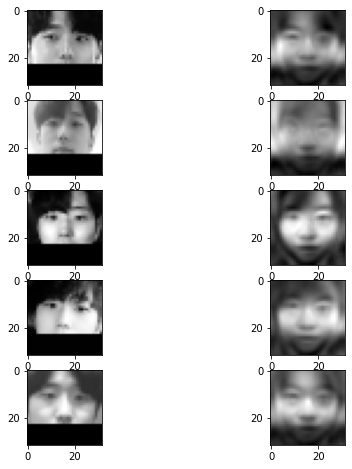

In [14]:
test_path = "./res/original/9/ex/"
test_file_list = os.listdir(test_path)
test_pics = []
weights = []
for test_file in test_file_list:
    pic = np.array(cv2.resize(cv2.imread(test_path + test_file, 0), dsize=(32, 32), interpolation=cv2.INTER_AREA), dtype=np.float64).flatten()
    pic = np.concatenate((pic[:512 + 224], np.array([1 for i in range(512 - 224)])))
    test_pics.append(pic)
    weights.append((pic - mean_of_pics) @ V.T)

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = len(test_file_list)
for i in range(rows):
    original_img = test_pics[i].reshape(32,32)
    w = np.diag(weights[i])
    restored_img = w @ V
    restored_img = (sum(restored_img[:56]) + mean_of_pics).reshape(32, 32)
    fig.add_subplot(rows, columns, 2*i + 1)
    plt.imshow(original_img, cmap='gray')
    fig.add_subplot(rows, columns, 2*i + 2)
    plt.imshow(restored_img, cmap='gray')
plt.show()